In [ ]:
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def set_seed(seed:int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
def data_setup(train_data:str,
               test_data:str,
               batch_size:int,
               num_workers:int = os.cpu_count()):

    class_names = train_data.classes

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return train_dataloader, test_dataloader, class_names

In [ ]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# CIFAR-10 class names
cifar10_classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

def prepare_cifar10_data(root_dir):
    # Download CIFAR-10 dataset
    transform = transforms.ToTensor()
    cifar10 = datasets.CIFAR10(root=root_dir, train=True, download=True, transform=transform)

    # Define paths for training and testing directories
    train_dir = os.path.join(root_dir, 'train')
    test_dir = os.path.join(root_dir, 'test')

    # Create directories for training and testing datasets
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Create subdirectories for each class
    for class_name in cifar10_classes.values():
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Split data into training and testing
    class_counts_train = {i: 0 for i in range(10)}
    class_counts_test = {i: 0 for i in range(10)}

    # Iterate over dataset
    for idx, (img, label) in enumerate(cifar10):
        class_name = cifar10_classes[label]
        pil_img = transforms.ToPILImage()(img)  # Convert tensor back to PIL image

        if class_counts_train[label] < 100:
            pil_img.save(os.path.join(train_dir, class_name, f'{class_name}_{class_counts_train[label]}.png'))
            class_counts_train[label] += 1
        elif class_counts_test[label] < 25:
            pil_img.save(os.path.join(test_dir, class_name, f'{class_name}_{class_counts_test[label]}.png'))
            class_counts_test[label] += 1

        # Stop if we have enough images
        if all(count == 100 for count in class_counts_train.values()) and all(count == 25 for count in class_counts_test.values()):
            break

    print(f'Training data saved in {train_dir}')
    print(f'Testing data saved in {test_dir}')

# Usage
root_dir = './cifar10_data'
prepare_cifar10_data(root_dir)


100%|██████████| 170498071/170498071 [00:15<00:00, 11108135.41it/s]


Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Training data saved in ./cifar10_data/train
Testing data saved in ./cifar10_data/test


In [ ]:
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    ])

In [ ]:
train_data = datasets.ImageFolder(root='./cifar10_data/train', transform=manual_transform)
test_data = datasets.ImageFolder(root='./cifar10_data/test', transform=manual_transform)

In [ ]:
BATCH_SIZE=16
train_dataloader, test_dataloader, class_names = data_setup(train_data,
                                                           test_data,
                                                           batch_size=BATCH_SIZE)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f2a74e9f0d0>,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [ ]:
len(train_dataloader)

63

In [ ]:
import matplotlib.pyplot as plt
# visualize a single image
image_batch, label_batch = next(iter(train_dataloader))
# get a single image
image, label = image_batch[0], label_batch[0]
print(f"Image shape: {image.shape}, Label: {label}")

Image shape: torch.Size([3, 224, 224]), Label: 2


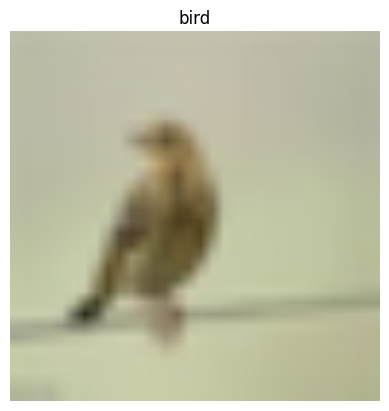

In [ ]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# get the vit model
import torch.nn as nn
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# freezing the params
for params in pretrained_vit.parameters():
    params.requires_grad = False

set_seed()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))

# apply automatic transform to the model
pretrained_vit_transfrom = pretrained_vit_weights.transforms()
print(pretrained_vit_transfrom)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 156MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
import torch
import os
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device) -> Tuple[float, float]:
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device) , y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()
    test_loss, test_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        test_pred_logits = model(x)
        loss = loss_fn(test_pred_logits, y)
        test_loss += loss.item()

        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        ### New: Experiment tracking ###
        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass

    return results

In [ ]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seed()
pretrained_vit.to(device)
pretrained_vit_results = train(model=pretrained_vit,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               loss_fn=loss_fn,
                               optimizer=optimizer,
                               epochs=10,
                               device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.1428 | train_acc: 0.7192 | test_loss: 0.5609 | test_acc: 0.8734
Epoch: 2 | train_loss: 0.4542 | train_acc: 0.8948 | test_loss: 0.3941 | test_acc: 0.8945
Epoch: 3 | train_loss: 0.3235 | train_acc: 0.9276 | test_loss: 0.3592 | test_acc: 0.9078
Epoch: 4 | train_loss: 0.2583 | train_acc: 0.9385 | test_loss: 0.3283 | test_acc: 0.9141
Epoch: 5 | train_loss: 0.2056 | train_acc: 0.9653 | test_loss: 0.3071 | test_acc: 0.9187
Epoch: 6 | train_loss: 0.1729 | train_acc: 0.9643 | test_loss: 0.2997 | test_acc: 0.9039
Epoch: 7 | train_loss: 0.1428 | train_acc: 0.9802 | test_loss: 0.3219 | test_acc: 0.8898
Epoch: 8 | train_loss: 0.1258 | train_acc: 0.9841 | test_loss: 0.2904 | test_acc: 0.9039
Epoch: 9 | train_loss: 0.1056 | train_acc: 0.9891 | test_loss: 0.2858 | test_acc: 0.9141
Epoch: 10 | train_loss: 0.0915 | train_acc: 0.9931 | test_loss: 0.2897 | test_acc: 0.9180


In [ ]:
from pathlib import Path
path_test = './cifar10_data/test'
print(f"[INFO] Finding all the file path with '.png' directory: {test_data}")
test_data_paths = list(Path(path_test).glob("*/*.png"))
test_data_paths[:5]


[INFO] Finding all the file path with '.png' directory: Dataset ImageFolder
    Number of datapoints: 250
    Root location: ./cifar10_data/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


[PosixPath('cifar10_data/test/horse/horse_8.png'),
 PosixPath('cifar10_data/test/horse/horse_1.png'),
 PosixPath('cifar10_data/test/horse/horse_6.png'),
 PosixPath('cifar10_data/test/horse/horse_23.png'),
 PosixPath('cifar10_data/test/horse/horse_13.png')]

In [ ]:
# a function to make predictions across the test dataset
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: torch.device) -> List[Dict]:
    pred_list = []

    for path in tqdm(paths):
        pred_dict = {}

        # get a path
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # start timer
        start_time = timer()

        # open image
        img = Image.open(path)
        transformed_image = transform(img).unsqueeze(0).to(device)
        # prepare the model for sending to the device
        model.to(device)
        model.eval()

         # getting the prediction
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # putting dictonary on the cpu
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)
        # is the pred correct or no
        pred_dict["correct"] = class_name == pred_class
        # add dict to the list
        pred_list.append(pred_dict)
    return pred_list

In [ ]:
test_pred_dict = pred_and_store(paths=test_data_paths,
                                model=pretrained_vit,
                                transform=pretrained_vit_transfrom,
                                class_names=class_names,
                                device=device)

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
test_pred_dict[:2]

[{'image_path': PosixPath('cifar10_data/test/horse/horse_8.png'),
  'class_name': 'horse',
  'pred_prob': 0.6436,
  'pred_class': 'automobile',
  'time_for_pred': 0.0679,
  'correct': False},
 {'image_path': PosixPath('cifar10_data/test/horse/horse_1.png'),
  'class_name': 'horse',
  'pred_prob': 0.9995,
  'pred_class': 'horse',
  'time_for_pred': 0.0204,
  'correct': True}]

In [ ]:
# creating it into a dataframes
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dict)
test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,cifar10_data/test/horse/horse_8.png,horse,0.6436,automobile,0.0679,False
1,cifar10_data/test/horse/horse_1.png,horse,0.9995,horse,0.0204,True
2,cifar10_data/test/horse/horse_6.png,horse,0.9985,horse,0.0194,True
3,cifar10_data/test/horse/horse_23.png,horse,0.9996,horse,0.0181,True
4,cifar10_data/test/horse/horse_13.png,horse,0.9989,horse,0.0176,True


In [ ]:
test_pred_df.correct.value_counts()

correct
True     227
False     23
Name: count, dtype: int64

In [ ]:
# # for gradio
# from typing import Tuple, TypedDict
# from PIL import Image
# def predict(img) -> Tuple[Dict, float]:
#     start_time = timer()
#     # img = Image.open(img)
#     if not isinstance(img, torch.Tensor):
#         img = Image.open(img)
#     img = pretrained_vit_transfrom(img).unsqueeze(0).to(device)
#     pretrained_vit.eval()

#     with torch.inference_mode():
#         pred_probs = torch.softmax(pretrained_vit(img), dim=1)
#     # creating prediction labels
#     pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
#     # calculating prediction time
#     pred_time = round(timer() - start_time, 5)

#     return pred_labels_and_probs, pred_time

In [ ]:
import random
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=25)]
example_list

[['cifar10_data/test/deer/deer_10.png'],
 ['cifar10_data/test/horse/horse_14.png'],
 ['cifar10_data/test/horse/horse_18.png'],
 ['cifar10_data/test/dog/dog_2.png'],
 ['cifar10_data/test/truck/truck_12.png'],
 ['cifar10_data/test/dog/dog_15.png'],
 ['cifar10_data/test/dog/dog_20.png'],
 ['cifar10_data/test/ship/ship_7.png'],
 ['cifar10_data/test/cat/cat_17.png'],
 ['cifar10_data/test/frog/frog_9.png'],
 ['cifar10_data/test/bird/bird_21.png'],
 ['cifar10_data/test/ship/ship_15.png'],
 ['cifar10_data/test/cat/cat_21.png'],
 ['cifar10_data/test/horse/horse_9.png'],
 ['cifar10_data/test/automobile/automobile_20.png'],
 ['cifar10_data/test/truck/truck_19.png'],
 ['cifar10_data/test/cat/cat_14.png'],
 ['cifar10_data/test/frog/frog_13.png'],
 ['cifar10_data/test/automobile/automobile_8.png'],
 ['cifar10_data/test/deer/deer_16.png'],
 ['cifar10_data/test/deer/deer_7.png'],
 ['cifar10_data/test/truck/truck_22.png'],
 ['cifar10_data/test/horse/horse_21.png'],
 ['cifar10_data/test/cat/cat_0.png'],

In [ ]:
# import gradio as gr

# title = "CIFAR-10_250_Test_Set"
# description = 'Using pre-trained ViT model for CIFAR-10_250_Test_Set, where the model is trained on 100 images per class.'
# article="by Dipanshu Singh"

# demo = gr.Interface(fn=predict,
#                     inputs=gr.Image(type="pil"),
#                     outputs=[gr.Label(num_top_classes=5, label="predictions"),
#                              gr.Number(label="Prediction Time")],
#                     examples=example_list,
#                     title=title,
#                     description=description,
#                     article=article)

# demo.launch(debug=True, share=True)

In [ ]:
!pip install gradio


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
from typing import Dict, Tuple
from timeit import default_timer as timer
import torch
from PIL import Image
import gradio as gr

# Ensure you have the necessary imports for your model and preprocessing
# from your_module import pretrained_vit, pretrained_vit_transfrom, class_names, device

def predict(img) -> Tuple[Dict, float]:
    start_time = timer()

    if isinstance(img, str):
        img = Image.open(img)
    elif isinstance(img, Image.Image):
        img = img
    else:
        raise ValueError("Invalid image input type")
    img = pretrained_vit_transfrom(img).unsqueeze(0).to(device)
    pretrained_vit.eval()

    with torch.inference_mode():
        pred_probs = torch.softmax(pretrained_vit(img), dim=1)

    # creating prediction labels
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    # calculating prediction time
    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time

title = "CIFAR-10_250_Test_Set"
description = 'Using pre-trained ViT model for CIFAR-10_250_Test_Set, where the model is trained on 100 images per class.'
article = "by Dipanshu Singh"

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=10, label="predictions"),
        gr.Number(label="Prediction Time")
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article
)

demo.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://945cfdf4634cc029b3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
